In [49]:
%pip install catboost


   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 1.3 MB/s eta 0:01:19
   ---------------------------------------- 0.0/101.1 MB 393.8 kB/s eta 0:04:17
   ---------------------------------------- 0.1/101.1 MB 930.9 kB/s eta 0:01:49
   ---------------------------------------- 0.1/101.1 MB 847.9 kB/s eta 0:02:00
   ---------------------------------------- 0.2/101.1 MB 1.2 MB/s eta 0:01:27
   ---------------------------------------- 0.3/101.1 MB 1.1 MB/s eta 0:01:31
   ---------------------------------------- 0.5/101.1 MB 1.7 MB/s eta 0:01:01
   ---------------------------------------- 0.6/101.1 MB 1.7 MB/s eta 0:00:58
   ---------------------------------------- 1.0/101.1 MB 2.6 MB/s eta 0:00:40
   ---------------------------------------- 1.1/101.1 MB 2.4 MB/s eta 0:00:42
   ---------------------------------------- 1.1/101.1 MB 2.5 MB/s eta 0:00:41
   ---------------------------------------- 1.1/101.1 MB 2.5 MB/s

In [51]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df = pd.read_csv('./climate_crop.csv')

# Create a 10% random sample of the data


In [53]:
def preprocess_data(df):
    # Handle missing values
    df = df.dropna()
    
    # Encode categorical features
    le_area = LabelEncoder()
    le_item = LabelEncoder()
    le_continent = LabelEncoder()
    df['Area'] = le_area.fit_transform(df['Area'])
    df['Item'] = le_item.fit_transform(df['Item'])
    df['Continent'] = le_continent.fit_transform(df['Continent'])
    
    # Select relevant columns
    X = df[['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']]
    y = df['hg/ha_yield']
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, le_area, le_item, le_continent, scaler 

In [54]:
X, y, le_area, le_item, le_continent, scaler = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# Feature selection with RFE
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)

In [56]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return {
        'MAE': mae,
        'MEDAE': medae,
        'MSE': mse,
        'RMSE': rmse,
        'Max Error': np.max(np.abs(y_test - y_pred)),
        'R2 Score': r2,
        'EVS': evs,
        'MAPE': mape
    }


In [57]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_rfe, y_train)
lr_results = evaluate_model(lr, X_test_rfe, y_test)
print(f"Linear Regression results: {lr_results}")

# Train RandomForestRegressor with hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_cv = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
rf_cv.fit(X_train_rfe, y_train)
rf_best = rf_cv.best_estimator_
rf_results = evaluate_model(rf_best, X_test_rfe, y_test)
print(f"RandomForestRegressor results: {rf_results}")

Linear Regression results: {'MAE': 64099.995570310806, 'MEDAE': 53626.39870865928, 'MSE': 7098843519.789056, 'RMSE': 84254.63500478212, 'Max Error': 394802.67224697734, 'R2 Score': 0.021344837717794163, 'EVS': 0.021352666458647085, 'MAPE': 2.4653259651815937}
Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


In [ ]:
# Train GradientBoostingRegressor with hyperparameter tuning
param_grid_gbr = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7]
}
gbr_cv = GridSearchCV(GradientBoostingRegressor(), param_grid_gbr, cv=3, n_jobs=-1, verbose=1)
gbr_cv.fit(X_train_rfe, y_train)
gbr_best = gbr_cv.best_estimator_
gbr_results = evaluate_model(gbr_best, X_test_rfe, y_test)
print(f"GradientBoostingRegressor results: {gbr_results}")

In [ ]:
# Train XGBRegressor with hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0]
}
xgb_cv = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
xgb_cv.fit(X_train_rfe, y_train)
xgb_best = xgb_cv.best_estimator_
xgb_results = evaluate_model(xgb_best, X_test_rfe, y_test)
print(f"XGBRegressor results: {xgb_results}")

In [ ]:
# Train SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train_rfe, y_train)
sgd_results = evaluate_model(sgd, X_test_rfe, y_test)
print(f"SGDRegressor results: {sgd_results}")

# Train CatBoostRegressor
cat = CatBoostRegressor(verbose=0)
cat.fit(X_train_rfe, y_train)
cat_results = evaluate_model(cat, X_test_rfe, y_test)
print(f"CatBoostRegressor results: {cat_results}")

# Collect results for comparison
df_results = pd.DataFrame({
    'Model': ['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'SGDRegressor', 'CatBoostRegressor'],
    'MAE': [lr_results['MAE'], rf_results['MAE'], gbr_results['MAE'], xgb_results['MAE'], sgd_results['MAE'], cat_results['MAE']],
    'MEDAE': [lr_results['MEDAE'], rf_results['MEDAE'], gbr_results['MEDAE'], xgb_results['MEDAE'], sgd_results['MEDAE'], cat_results['MEDAE']],
    'MSE': [lr_results['MSE'], rf_results['MSE'], gbr_results['MSE'], xgb_results['MSE'], sgd_results['MSE'], cat_results['MSE']],
    'RMSE': [lr_results['RMSE'], rf_results['RMSE'], gbr_results['RMSE'], xgb_results['RMSE'], sgd_results['RMSE'], cat_results['RMSE']],
    'Max Error': [lr_results['Max Error'], rf_results['Max Error'], gbr_results['Max Error'], xgb_results['Max Error'], sgd_results['Max Error'], cat_results['Max Error']],
    'R2 Score': [lr_results['R2 Score'], rf_results['R2 Score'], gbr_results['R2 Score'], xgb_results['R2 Score'], sgd_results['R2 Score'], cat_results['R2 Score']],
    'EVS': [lr_results['EVS'], rf_results['EVS'], gbr_results['EVS'], xgb_results['EVS'], sgd_results['EVS'], cat_results['EVS']],
    'MAPE': [lr_results['MAPE'], rf_results['MAPE'], gbr_results['MAPE'], xgb_results['MAPE'], sgd_results['MAPE'], cat_results['MAPE']]
})

# Print results
print(df_results)

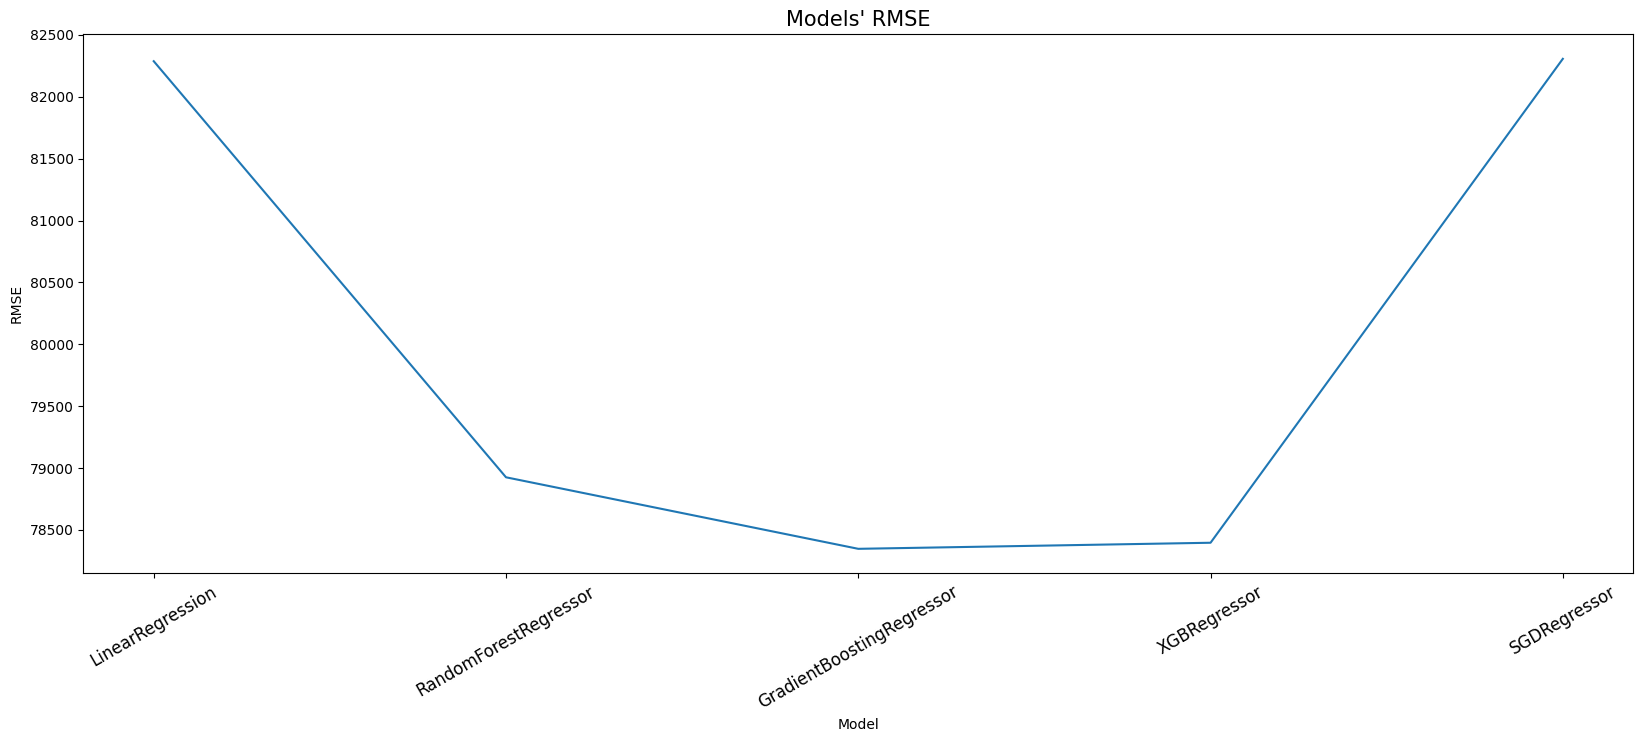

NameError: name 'gbr_best' is not defined

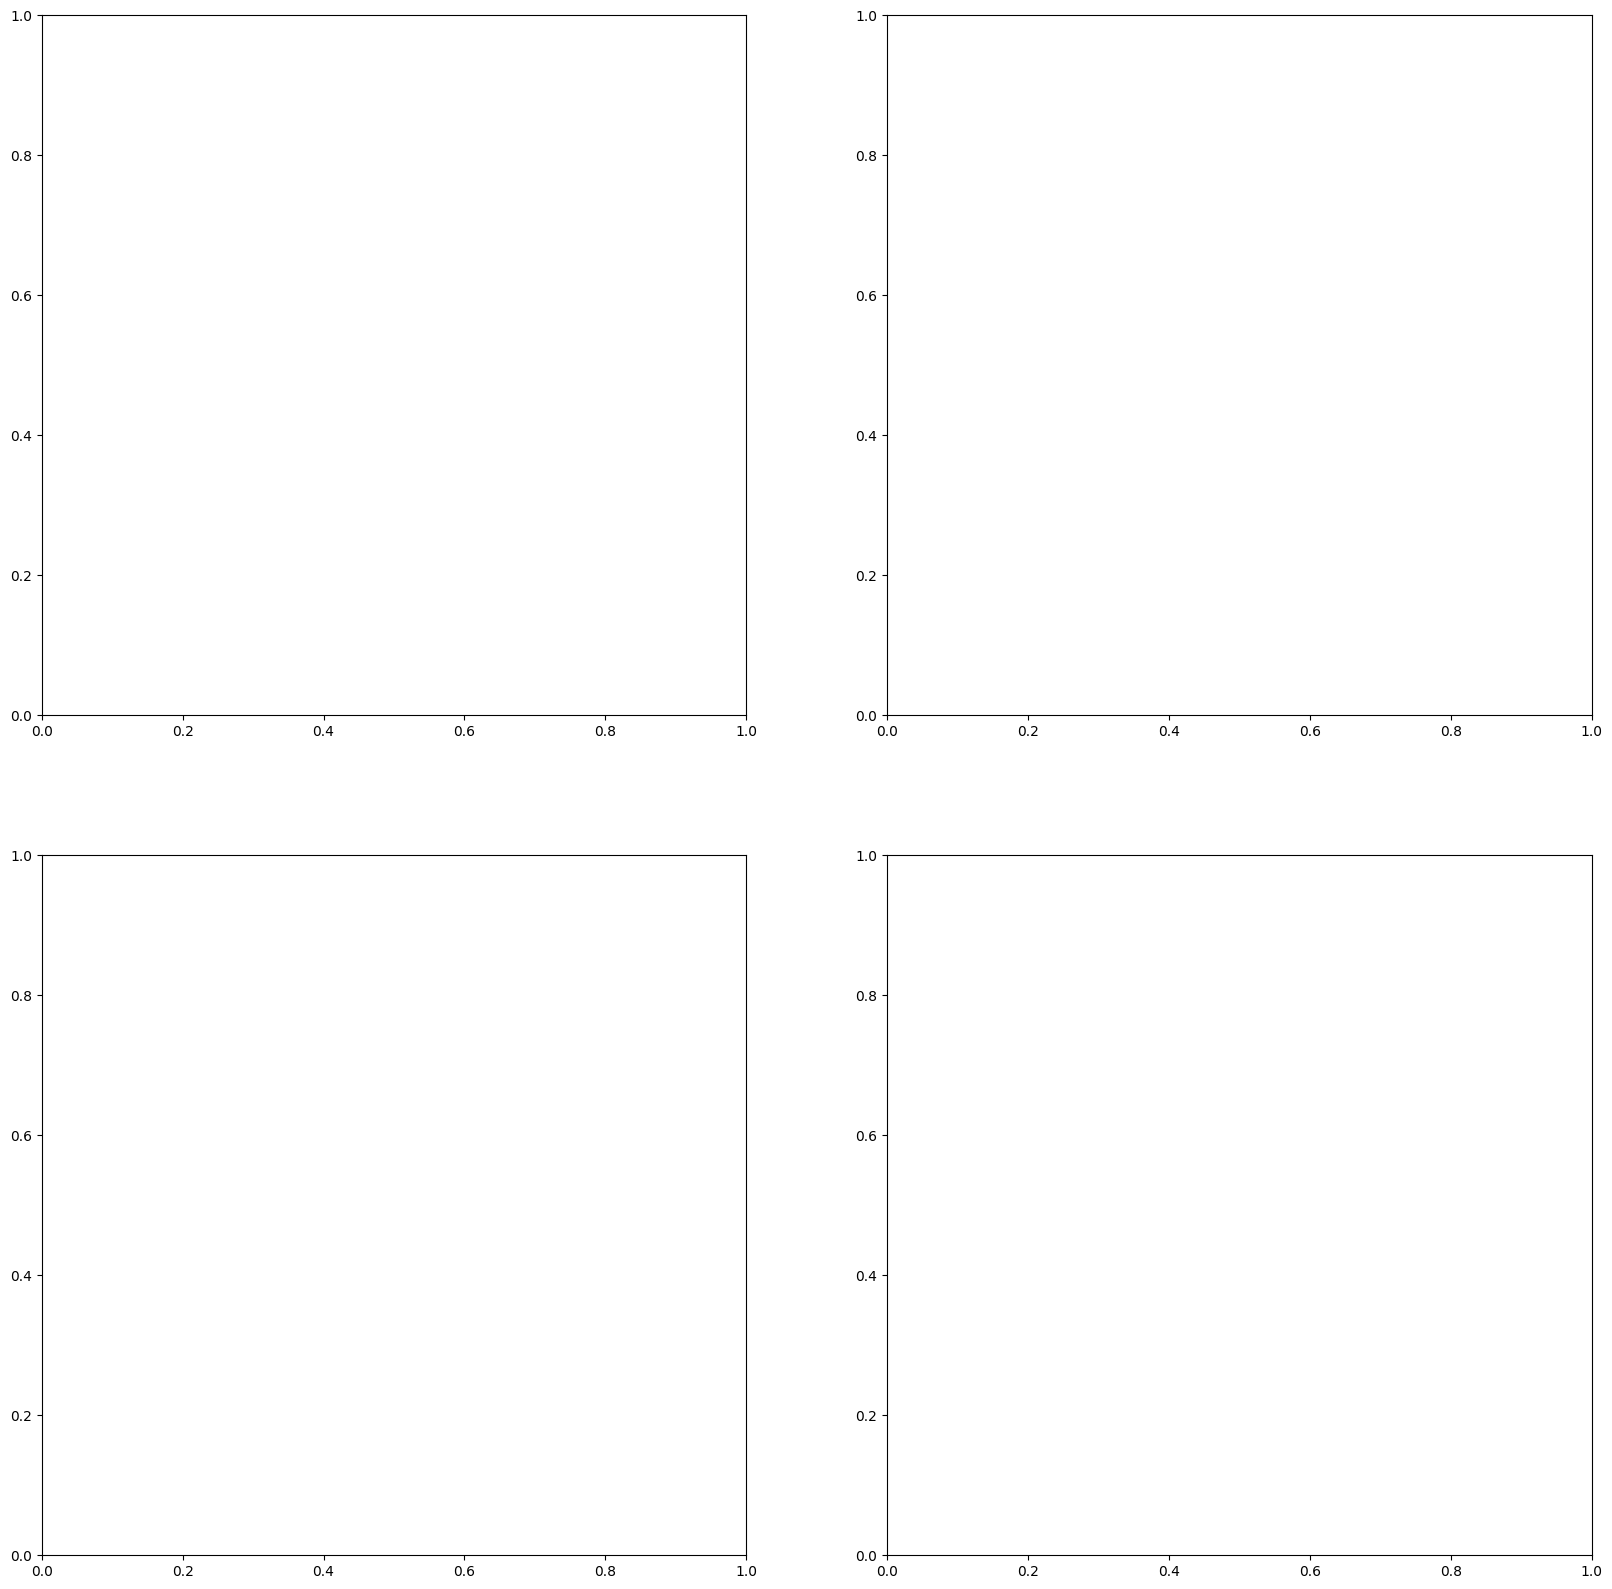

In [50]:
# Plot RMSE of all models
plt.figure(figsize=(20,7))
sns.lineplot(x=df_results.Model, y=df_results.RMSE)
plt.title("Models' RMSE", size=15)
plt.xticks(rotation=30, size=12)
plt.show()

# Visualize the performance of various models
fig, plotcanvas = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Gradient Boosting Regressor
gbr_pred = gbr_best.predict(X_test_rfe)
c = df_results[df_results['Model'] == 'GradientBoostingRegressor']['R2 Score'].values[0]
plotcanvas[0, 0].scatter(y_test, gbr_pred, s=20)
plotcanvas[0, 0].set_title(f'Gradient Boosting Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[0, 0].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[0, 0].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

# Random Forest Regressor
rfr_pred = rf_best.predict(X_test_rfe)
c = df_results[df_results['Model'] == 'RandomForestRegressor']['R2 Score'].values[0]
plotcanvas[0, 1].scatter(y_test, rfr_pred, s=20)
plotcanvas[0, 1].set_title(f'Random Forest Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[0, 1].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[0, 1].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

# SGD Regressor
sgd_pred = sgd.predict(X_test_rfe)
c = df_results[df_results['Model'] == 'SGDRegressor']['R2 Score'].values[0]
plotcanvas[1, 0].scatter(y_test, sgd_pred, s=20)
plotcanvas[1, 0].set_title(f'SGD Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[1, 0].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[1, 0].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

# XGB Regressor
xgb_pred = xgb_best.predict(X_test_rfe)
c = df_results[df_results['Model'] == 'XGBRegressor']['R2 Score'].values[0]
plotcanvas[1, 1].scatter(y_test, xgb_pred, s=20)
plotcanvas[1, 1].set_title(f'XGB Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[1, 1].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[1, 1].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

plt.tight_layout()
plt.show()

# CatBoost Regressor visualization
fig, ax = plt.subplots(figsize=(10, 7))
cat_pred = cat.predict(X_test_rfe)
c = df_results[df_results['Model'] == 'CatBoostRegressor']['R2 Score'].values[0]
ax.scatter(y_test, cat_pred, s=20)
ax.set_title(f'CatBoost Regressor with {c:.4f} R2 Score', fontsize=20)
ax.set_xlabel('Actual Crop Production', fontsize=15)
ax.set_ylabel('Predicted Crop Production', fontsize=15)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)
plt.show()

# Linear Regression visualization
fig, ax = plt.subplots(figsize=(10, 7))
lr_pred = lr.predict(X_test_rfe)
c = df_results[df_results['Model'] == 'LinearRegression']['R2 Score'].values[0]
ax.scatter(y_test, lr_pred, s=20)
ax.set_title(f'Linear Regression with {c:.4f} R2 Score', fontsize=20)
ax.set_xlabel('Actual Crop Production', fontsize=15)
ax.set_ylabel('Predicted Crop Production', fontsize=15)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)
plt.show()


In [ ]:
# end

In [41]:
def train_models(X_train, y_train):
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'XGBRegressor': XGBRegressor(),
        'SGDRegressor': SGDRegressor()
    }
    
    param_dist_rf = {
        'n_estimators': [100, 200],
        'max_features': ['sqrt', None],
        'max_depth': [5, 10],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5],
        'bootstrap': [True, False]
    }
    
    param_dist_gbr = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
    
    param_dist_xgb = {
        'n_estimators': [100, 500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }
    
    rf_cv = RandomizedSearchCV(RandomForestRegressor(), param_dist_rf, cv=3, n_iter=8, verbose=0, random_state=42)
    gbr_cv = RandomizedSearchCV(GradientBoostingRegressor(), param_dist_gbr, cv=3, n_iter=8, verbose=0, random_state=42)
    xgb_cv = RandomizedSearchCV(XGBRegressor(), param_dist_xgb, cv=3, n_iter=8, verbose=0, random_state=42)
    
    model_cv = {
        'RandomForestRegressor': rf_cv,
        'GradientBoostingRegressor': gbr_cv,
        'XGBRegressor': xgb_cv
    }
    
    trained_models = {}
    for model_name, model in models.items():
        if model_name in model_cv:
            model_cv[model_name].fit(X_train, y_train)
            trained_models[model_name] = model_cv[model_name].best_estimator_
        else:
            model.fit(X_train, y_train)
            trained_models[model_name] = model
    
    return trained_models 

In [42]:
trained_models = train_models(X_train, y_train)


In [43]:
def evaluate_models(models, X_test, y_test):
    results = []
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append({
            'Model': model_name,
            'MAE': mae,
            'MEDAE': medae,
            'MSE': mse,
            'RMSE': rmse,
            'Max Error': np.max(np.abs(y_test - y_pred)),
            'R2 Score': r2,
            'EVS': evs,
            'MAPE': mape
        })
    return pd.DataFrame(results)

In [44]:
df_results = evaluate_models(trained_models, X_test, y_test)


In [45]:
df_results = evaluate_models(trained_models, X_test, y_test)
print(df_results)

                       Model           MAE         MEDAE           MSE  \
0           LinearRegression  62941.933108  53829.701344  6.771296e+09   
1      RandomForestRegressor  61431.648318  50564.751346  6.229158e+09   
2  GradientBoostingRegressor  60777.468344  49733.818218  6.138235e+09   
3               XGBRegressor  60785.103637  49285.164062  6.145928e+09   
4               SGDRegressor  63111.902614  54723.035437  6.774459e+09   

           RMSE      Max Error  R2 Score       EVS      MAPE  
0  82287.885888  381979.961456  0.014625  0.015267  2.774812  
1  78925.017480  364093.060337  0.093518  0.093868  2.416818  
2  78346.889525  356320.889570  0.106749  0.107018  2.357298  
3  78395.967888  364480.835938  0.105630  0.105814  2.373845  
4  82307.102624  383490.330658  0.014164  0.015615  2.789475  


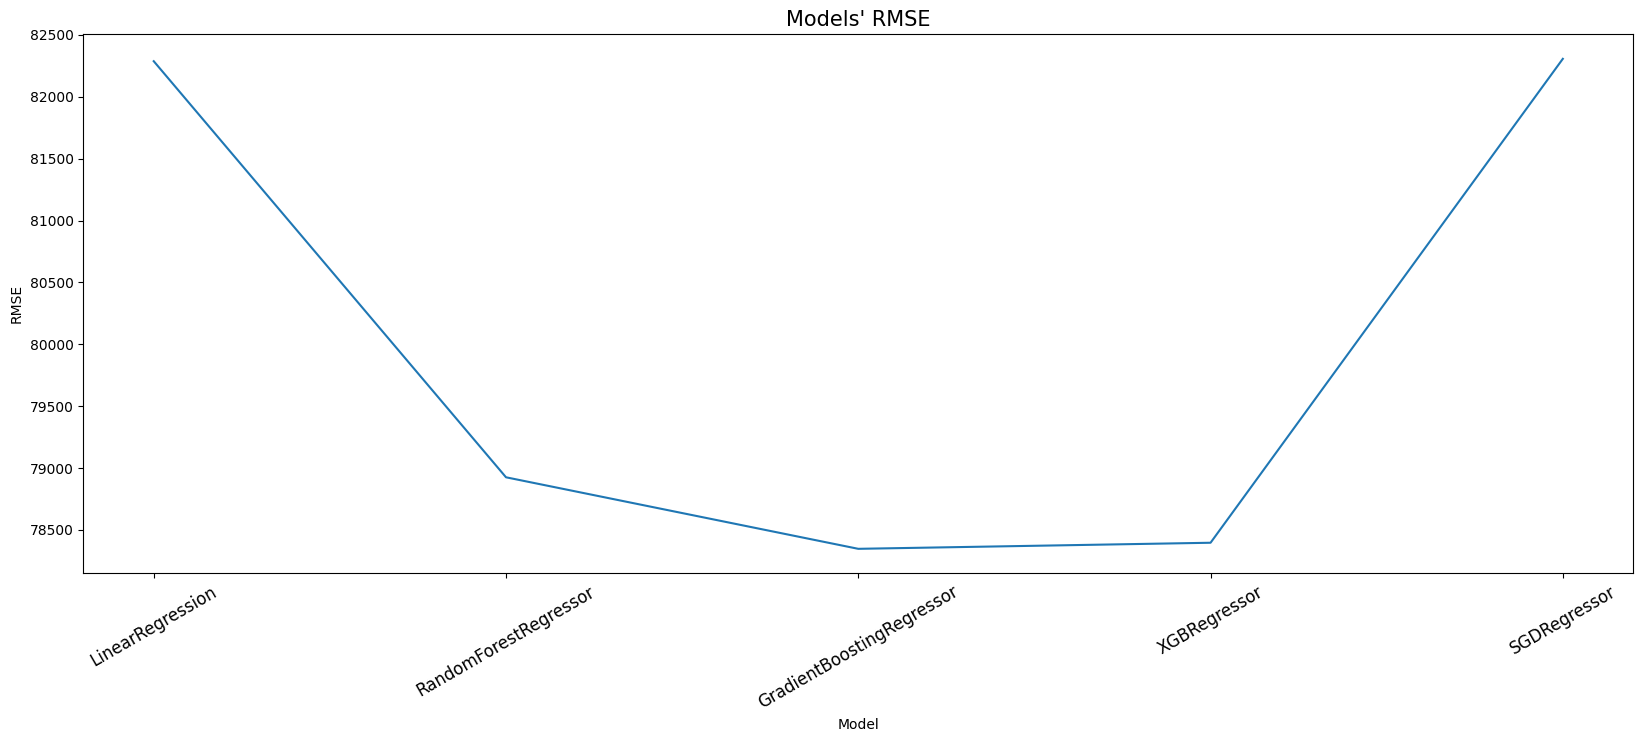

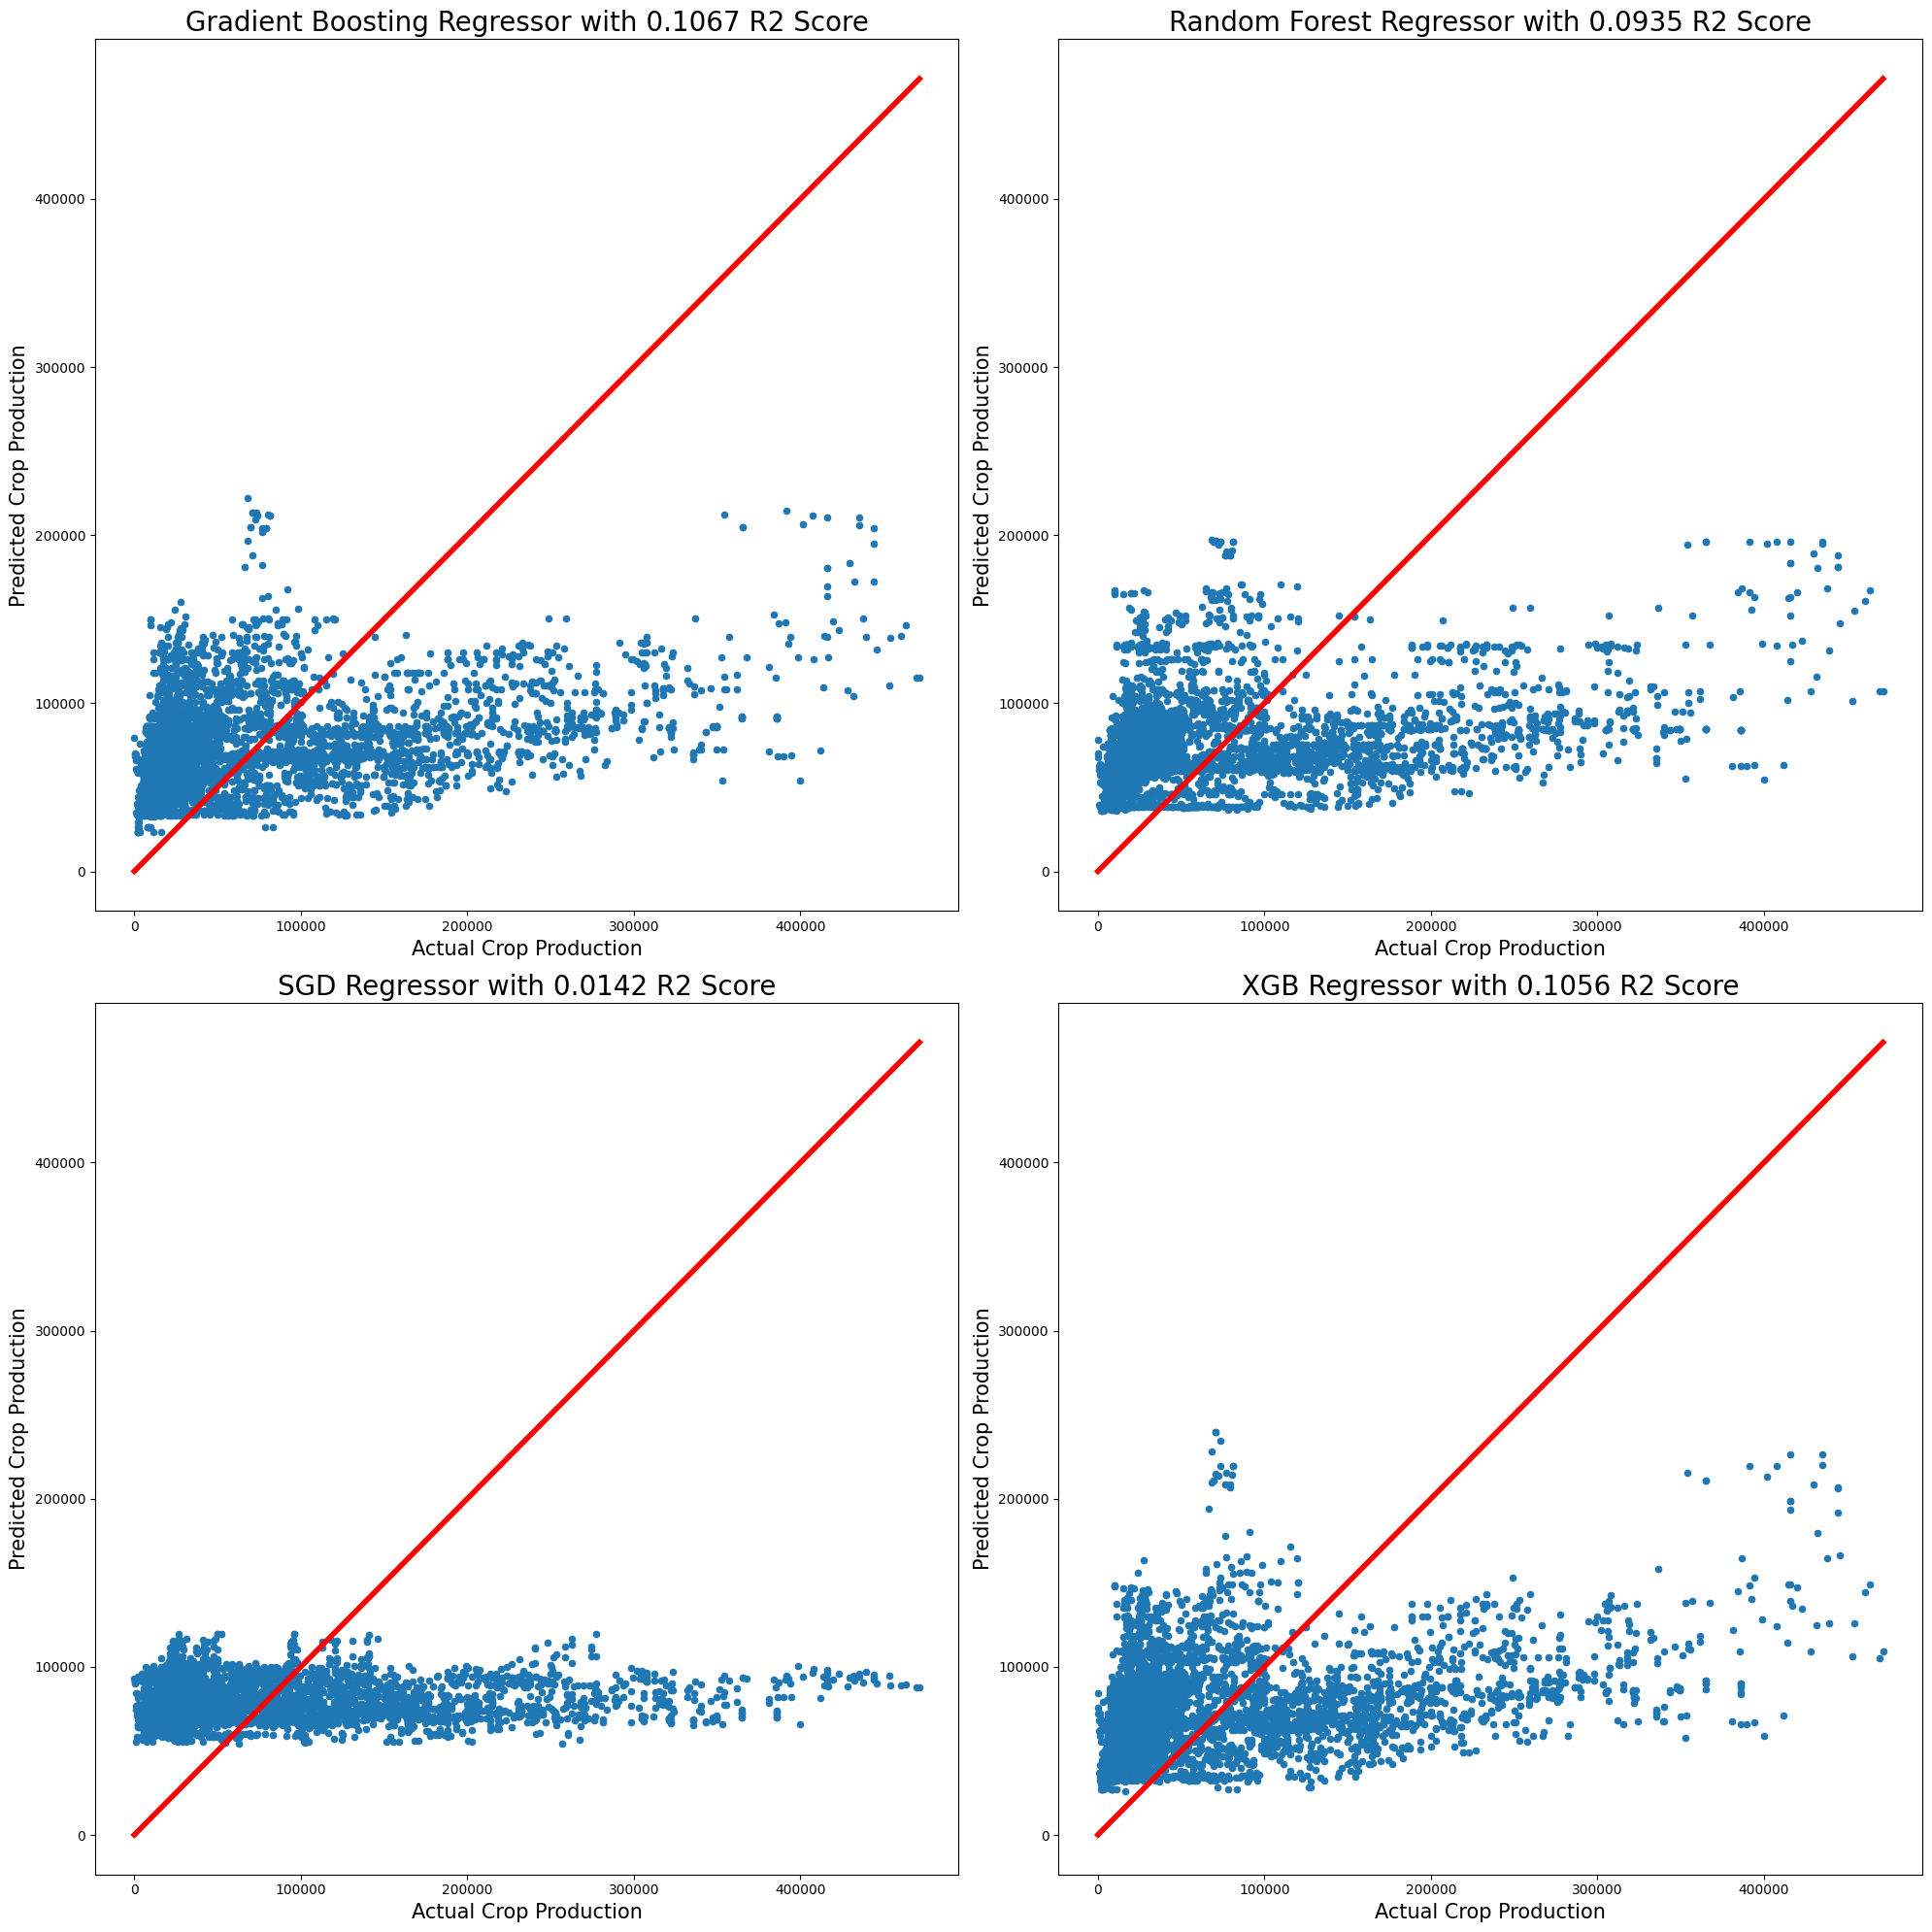

In [46]:
# Plot RMSE of all models
plt.figure(figsize=(20,7))
sns.lineplot(x=df_results.Model, y=df_results.RMSE)
plt.title("Models' RMSE", size=15)
plt.xticks(rotation=30, size=12)
plt.show()

# Visualize the performance of various models
fig, plotcanvas = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Gradient Boosting Regressor
gbr_pred = trained_models['GradientBoostingRegressor'].predict(X_test)
c = df_results[df_results['Model'] == 'GradientBoostingRegressor']['R2 Score'].values[0]
plotcanvas[0, 0].scatter(y_test, gbr_pred, s=20)
plotcanvas[0, 0].set_title(f'Gradient Boosting Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[0, 0].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[0, 0].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

# Random Forest Regressor
rfr_pred = trained_models['RandomForestRegressor'].predict(X_test)
c = df_results[df_results['Model'] == 'RandomForestRegressor']['R2 Score'].values[0]
plotcanvas[0, 1].scatter(y_test, rfr_pred, s=20)
plotcanvas[0, 1].set_title(f'Random Forest Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[0, 1].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[0, 1].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

# SGD Regressor
sgd_pred = trained_models['SGDRegressor'].predict(X_test)
c = df_results[df_results['Model'] == 'SGDRegressor']['R2 Score'].values[0]
plotcanvas[1, 0].scatter(y_test, sgd_pred, s=20)
plotcanvas[1, 0].set_title(f'SGD Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[1, 0].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[1, 0].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

# XGB Regressor
xgb_pred = trained_models['XGBRegressor'].predict(X_test)
c = df_results[df_results['Model'] == 'XGBRegressor']['R2 Score'].values[0]
plotcanvas[1, 1].scatter(y_test, xgb_pred, s=20)
plotcanvas[1, 1].set_title(f'XGB Regressor with {c:.4f} R2 Score', fontsize=20)
plotcanvas[1, 1].set_xlabel('Actual Crop Production', fontsize=15)
plotcanvas[1, 1].set_ylabel('Predicted Crop Production', fontsize=15)
plotcanvas[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=4)

plt.tight_layout()
plt.show()


In [47]:
# Function to make predictions and map to "Item" and "Area"
def make_predictions(models, X_new, le_area, le_item, le_continent, scaler):
    X_new_scaled = scaler.transform(X_new)
    predictions = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_new_scaled)
        predictions[model_name] = y_pred
    return predictions

# User input for new data
def user_input():
    new_data = {
        'average_rain_fall_mm_per_year': float(input("Enter average rain fall (mm per year): ")),
        'pesticides_tonnes': float(input("Enter pesticides used (tonnes): ")),
        'avg_temp': float(input("Enter average temperature: "))
    }
    return new_data


In [48]:
# Convert user input to DataFrame
def prepare_user_input(new_data):
    X_new = pd.DataFrame([new_data])
    return X_new


In [ ]:
# Predict using user input
new_data = user_input()
X_new = prepare_user_input(new_data)
predictions = make_predictions(trained_models, X_new, le_area, le_item, le_continent, scaler)


In [ ]:
# Show predictions
for model_name, y_pred in predictions.items():
    print(f"{model_name} Prediction: {y_pred[0]} hg/ha_yield")

# Find the best Item and Area
best_model_name = max(predictions, key=lambda k: predictions[k][0])
best_yield = predictions[best_model_name][0]
print(f"Best model: {best_model_name} with predicted yield: {best_yield} hg/ha_yield")

# Mapping back to original Item and Area based on the best model
area_pred = le_area.inverse_transform([0])[0]  # Placeholder value (to be updated based on your logic)
item_pred = le_item.inverse_transform([0])[0]  # Placeholder value (to be updated based on your logic)
continent_pred = le_continent.inverse_transform([0])[0]  # Placeholder value (to be updated based on your logic)
print(f"Suggested Item: {item_pred}, Similar Area: {area_pred}, Continent: {continent_pred}")